# Gaussian process time series
*David Wells*

[Home Page](https://dawells.github.io/index.html)

[Part 1: Additive mixed model](https://dawells.github.io/posts/GAMM.html)

Part 2 applying **Gaussian Process Regression** to time series.

## Recap
Our aim is to predict mongoose weight throughout their life. Plots show that they increase in weight rapidly for their first few years before leveling off and possibly decreasing in later life. This is the second type of modeling we have tried for this time series data.

# Preprocessing
This section mostly mimics the preprocessing done in the last post but this time in Python rather than R. However, we do also centre to weights so that the mean is zero.

In [38]:
#Import libraries
import os
import numpy as np
import pandas as pd
pd.options.display.max_rows = 6
pd.options.display.max_columns = 13

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared, WhiteKernel

In [39]:
#Set working directory

os.chdir("/Users/davidwells/Dropbox/Statistics/weight_time/data")
os.getcwd()

'/Users/davidwells/Dropbox/Statistics/weight_time/data'

In [40]:
################################
#                              #
#      Data preprocessing      #
#                              #
################################

#Load data.
data = pd.read_csv("rawdata/mongoose WEIGHTS.csv")
lhdata = pd.read_csv("rawdata/lhdata_march_2019.csv")

#Remove stupid named individuals.
bad_id = ["UM PUP", "UM PUP1", "UM PUP2", "UM PUP3", "UM AD", "UM F", "UM SUB", "UMSUB", "UNK", "", "BP375", "BP372"]
lhdata = lhdata[-lhdata.indiv.isin(bad_id)]

#Format dates.
#ALWAYS specify date format because its so easy to misinterpret, pandas assumes your data is mdy.
#Specifying also speeds up code.
data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y")
lhdata['date'] = pd.to_datetime(lhdata['date'], format="%Y-%m-%d")

#Sort by dates.
data = data.sort_values(by="date")

#Get birthdays.
born = lhdata[(lhdata.stend == "START") & (lhdata.code == "BORN")]

#Check duplicates
born[born.duplicated(subset="indiv")]

#Add age to data
data = pd.merge(data, born[['indiv', 'date']], how="left", on="indiv")
data.rename(columns={"date_x":"date","date_y":"dob"}, inplace=True)
data['age'] = data.date - data.dob
#age as numeric
data['agen'] = data['age'].dt.days

#Get month for seasonal effect
data['month'] = data.date.dt.strftime("%b")

#Remove NAs.
data = data.dropna(subset=["weight", "age"])

#Remove outright outliers.
data = data[(data.weight < 4000) & (data.age > pd.Timedelta(0))]

#Mean centre weight
data['weightc'] = data.weight - data.weight.mean()

#For the R functions, working for timeseries requires at most a single point per day per individual.
#Therefore we have to remove any within day duplications of individuals.
#Data single record

iddate = data.duplicated(subset=['indiv','date'])
dsr = data[-iddate]

# Split datasets
Split the data into training, validation and test datasets. Because this is time series data we split the data into separate time chunks rather than taking random draws.

Training is only a subsample of the data available because its just a demonstration and models with all the data are very slow.

In [100]:
train = dsr[(dsr.date < "2010-01-01") & (dsr.date >= "2007-01-01")].sample(2000, replace=False)
#The training data is too large and slow for our purposes, subset it.
val = dsr[(dsr.date >= "2010-01-01") & (dsr.date <= "2013-01-01")]
test = dsr[(dsr.date > "2013-01-01")]


# Data Exploration
First we plot the age of individuals against their weight for the training data. This allows us to see the overall trend.

Second we look at two individuals to see how individual weights vary. This makes it easier to see the autocorrelation and the amount of variation within individual weights. Note that the scale on the second figure is much smaller, making early growth appear less steep.

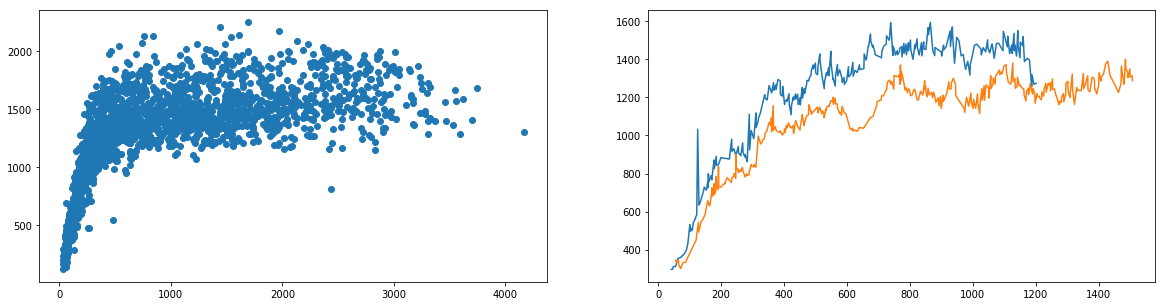

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(train.agen, train.weight, "o")
ax2.plot("agen", "weight", "-", data=dsr[(dsr.indiv=="FM142") & (dsr.weight<1900)])
ax2.plot("agen", "weight", "-", data=dsr[(dsr.indiv=="FM105") & (dsr.weight<1900)])

# Fit models
We'll fit a 2D gaussian process regression using using individual age and month as input variables. This allows us to capture the anual weather effects on weight. We could also include date to account for differences between years.

Given the cyclical nature of the seasons it would be reasonable to fit month with a cyclic covariance function such as `ExpSineSquare()`. However, in this case this provides no improvment over a simpler squared exponential function `RBF()` which can account for different length scales across the various input variables. In the previous post we found that a cyclical month effect was significant but small compared to other effects and mostly driven by a single month. Therefore, it seems that `RBF()` is able to capture the effect without being explictily cyclical.

# Age and month

In [102]:
#Fit gp to both age and month with a constant and exponential kernal

am = pd.concat([train.agen, train.date.dt.month], axis=1)
am.columns = ["agen", "monthn"]

kamc = ConstantKernel(1, (1e-5,1e5))*RBF([10,10], (1e-5,1e5)) +WhiteKernel()
gpamc = GaussianProcessRegressor(kernel=kamc, alpha=10, n_restarts_optimizer=9)
gpamc.fit(am.values, train.weightc.values)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=[10, 10]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [103]:
print(gpamc.kernel_)

316**2 * RBF(length_scale=[277, 3.58e+04]) + WhiteKernel(noise_level=3.79e+04)


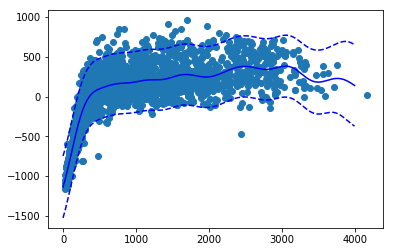

In [105]:
p_age = pd.Series(range(0,4000,30))
p_m = pd.Series(1).repeat(p_age.shape[0])
p_m.index=p_age.index
p_am = pd.concat([p_age,p_m], axis=1)

pamc, sigmamc = gpamc.predict(p_am, return_std=True)

plt.plot(train.agen, train.weightc, "o")
plt.plot(p_age, pamc, "b-")
plt.plot(p_age, pamc+(1.96*sigmamc), "b--")
plt.plot(p_age, pamc-(1.96*sigmamc), "b--")

In [106]:
am_val = pd.concat([val.agen, val.date.dt.month], axis=1)
am_val.columns = ["agen", "monthn"]

print(gpamc.score(am_val.values, val.weightc))

0.7321921935050656


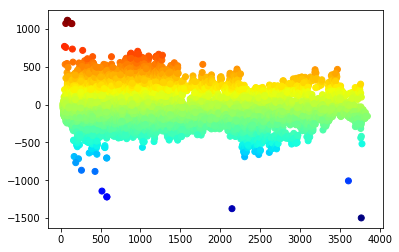

In [107]:
#Residuals
val_pred = gpamc.predict(am_val.values)
val_resid = val.weightc - val_pred
plt.scatter(am_val.agen, val_resid, c=val_resid, cmap="jet")

The above plot of the residuals from the validation dataset don't show any major problems, but there are some poor predictions from the first 500 days of life. The plot below, where predictions are split by month, shows roughly the same spread for each month. This implies that our kernel has captured the monthly effects without being explicitly periodic.

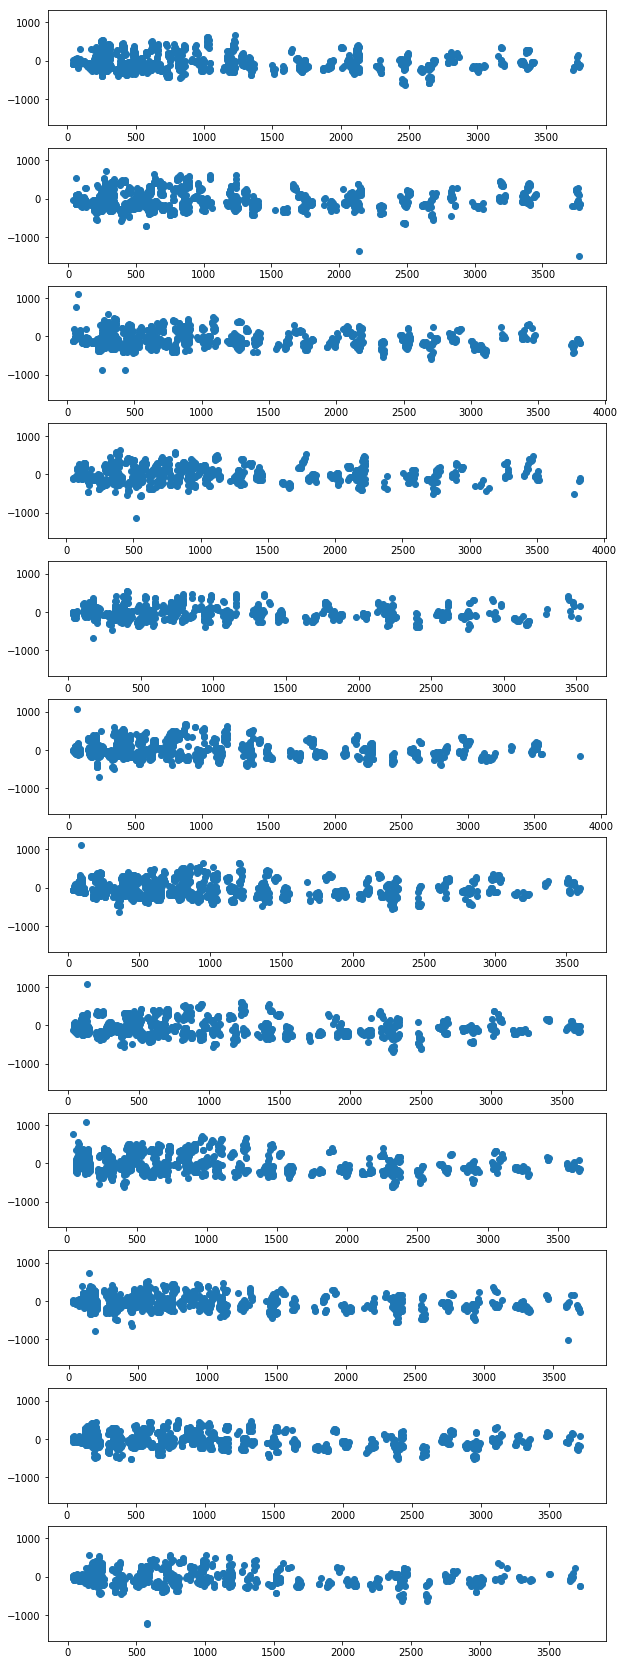

In [109]:
fig, axs = plt.subplots(12,1, figsize = (10,30), sharey=True)
for i in range(1,13):
    axs[i-1].scatter(am_val[am_val.monthn == i].agen, val_resid[am_val.monthn == i])